# A script that generate images in the output folder : non attacked, saliency non attacked, attacked, saliency attacked (with all combinaisons of : models, attacks, effect of attack)

In [7]:
#!pip install tf-keras-vis

In [4]:
print("Executing : Load libraries")

import os
# uncomment to force the non use of GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

from keras.utils import load_img, img_to_array, array_to_img

import foolbox as fb
from foolbox.criteria import TargetedMisclassification
from foolbox.attacks import PGD

from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions

from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.saliency import Saliency

from PIL import Image, ImageChops, ImageEnhance

import numpy as np
import cv2
from scipy.stats import pearsonr
from skimage.metrics import structural_similarity as ssim

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

path_project_root = os.path.dirname(os.path.abspath(''))

Executing : Load libraries
Tensorflow recognized 0 GPUs


# SALIENCY

In [9]:
def load_model(model_name="MobileNetV2"):
    """
        Return the selected model. Argument : name of the model.
    """
    print("Executing : Load Model")
    model=""
    if model_name=="VGG16":
        from keras.applications.vgg16 import VGG16 as Model
        model = Model(weights='imagenet', include_top=True)
    elif model_name=="MobileNetV2":
        from keras.applications.mobilenet_v2 import MobileNetV2 as Model
        model = Model(weights='imagenet', include_top=True)
    elif model_name=="ResNet152V2":
        from keras.applications.resnet_v2 import ResNet152V2 as Model
        model = Model(weights='imagenet', include_top=True)
    else:
        print("Error : model not available")
        raise NameError()
    return model

def get_image(path, size=(224,224), model_name="MobileNetV2"):
    print("Executing : Load And Preprocess Image")
    image= load_img(path)
    image = tf.cast(image, tf.float32)
    if model_name=="VGG16":
        image = tf.keras.applications.vgg16.preprocess_input(image)
    elif model_name=="MobileNetV2":
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    elif model_name=="MobileNetV2":
        image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image

def get_score_function(index_list):
    print("Executing : Create Score Function")
    return CategoricalScore(index_list)

def get_saliency_object(model):
    print("Executing : Create Saliency Object")
    replace2linear = ReplaceToLinear()
    saliency = Saliency(model, model_modifier=replace2linear, clone=True)
    return saliency

# ATTACK

In [5]:
def get_attacked_image_FGSM(image, debug = False, attack_rate = 15): #attack_rate entre 0 et 100

    pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
    pretrained_model.trainable = False

    # ImageNet labels
    decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    #image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]

    image_probs = pretrained_model.predict(image)

   
    if debug :  
      plt.figure()
      plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
    _, image_class, class_confidence = decode_predictions(image_probs, top=1)[0][0]
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    if debug :
      plt.show()

    loss_object = tf.keras.losses.CategoricalCrossentropy()

    image_index = 413 #goldfish = 1; brown bear = 294; assault rifle = 413
    label = tf.one_hot(image_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

   

    with tf.GradientTape() as tape:
      tape.watch(image)
      prediction = pretrained_model(image)
      loss = loss_object(label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    perturbations = signed_grad
    if debug :
      plt.figure()
      plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]
      plt.show()

    #epsilons = [0, 0.01, 0.1, 0.15] #noter "taux d'attaque"
    descriptions = ['Epsilon = {:0.3f}'.format(attack_rate)]
    
    #for i, eps in enumerate(epsilons):
    adv_x = image + (attack_rate/100)*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, label, confidence = decode_predictions(pretrained_model.predict(adv_x), top=1)[0][0]
    
    if debug :
      plt.figure() 
      plt.imshow(adv_x[0]*0.5+0.5)
    im = np.array(adv_x[0]*0.5 + 0.5)
    # plt.imsave(os.path.join(path_project_root, 'attack_and_saliency\images\image_attacked.png'), im) #Endroit où sauvegarder l'image attaqué (Changer le path si besoin)
    if debug :
      plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[3], label, confidence*100))
      plt.show()

    attacked_image = im
    return attacked_image

def get_attacked_image_PGD(orig_img, debug = False,  attack_rate = 10, class_target = 2) : #class_target c'est la classe que l'on cherche à appliquer

    model = ResNet50()

    height = model.layers[0].input_shape[0][1]
    width = model.layers[0].input_shape[0][2]
    channels = model.layers[0].input_shape[0][3]

    orig_img = orig_img.resize((width, int(orig_img.size[1] * width / orig_img.size[0])))

    img_width, img_height = orig_img.size
    left = (img_width - width)/2
    top = (img_height - height)/2
    right = (img_width + width)/2
    bottom = (img_height + height)/2

    orig_img = orig_img.crop((left, top, right, bottom))

    plt.figure()
    plt.imshow(np.array(orig_img))
    plt.show()

    orig_input = img_to_array(orig_img)
    orig_input = orig_input.reshape((1, width, height, channels))
    orig_input = preprocess_input(orig_input)

    predictions = model.predict(orig_input)

    if debug :
      labels = decode_predictions(predictions)
      kind = labels[0][0][1].replace("_", " ").title()
      percent = round(labels[0][0][2] * 100, 2)
      print(f"This is a {kind}. I am {percent} % sure.")
      print()
      print("Other suggestions:")
      for i in range(4):
        kind = labels[0][i+1][1].replace("_", " ").title()
        percent = round(labels[0][i+1][2] * 100, 2)
        print(f"{kind}: {percent} %")

    fmodel = fb.TensorFlowModel(model, bounds=(-255, 255))

   
    #goldfish = 1; brown bear = 294; assault rifle = 413 #class de notre image
    # 2 = great white shark #classe que l'on cherche à obtenir
    adv_label = tf.convert_to_tensor([class_target])

    criterion = TargetedMisclassification(adv_label)


    attack = PGD()
    input_as_tensor = tf.convert_to_tensor(orig_input)
    adv_input = attack.run(fmodel, input_as_tensor, criterion, attack_rate)

    adv_img = (adv_input.numpy() + 255) / 2
    adv_img = adv_img.reshape(width, height, channels)
    adv_img = array_to_img(adv_img)
    b, g, r = adv_img.split()
    adv_img = Image.merge("RGB", (r, g, b))

    adv_input = img_to_array(adv_img)
    adv_input = adv_input.reshape((1, width, height, channels))
    adv_input = preprocess_input(adv_input)
    predictions = model.predict(adv_input)
    
    if debug :
      labels = decode_predictions(predictions)
      kind = labels[0][0][1].replace("_", " ").title()
      percent = round(labels[0][0][2] * 100, 2)
      print(f"This is a {kind}. I am {percent} % sure.")
      print()
      print("Other suggestions:")
      for i in range(4):
        kind = labels[0][i+1][1].replace("_", " ").title()
        percent = round(labels[0][i+1][2] * 100, 2)
        print(f"{kind}: {percent} %")

    difference = ImageChops.difference(adv_img, orig_img)
    plt.figure()
    plt.imshow(np.array(difference))
    plt.show()

    difference = ImageEnhance.Brightness(difference).enhance(10)
    plt.figure()
    plt.imshow(np.array(difference))
    plt.show()

    return np.array(adv_img)

# ERROR in PGD

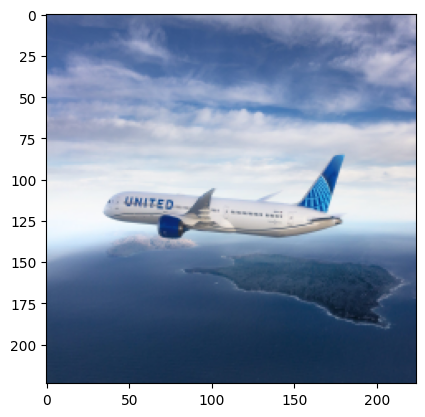

102967424/102967424 [==============================] - 119s 1us/step


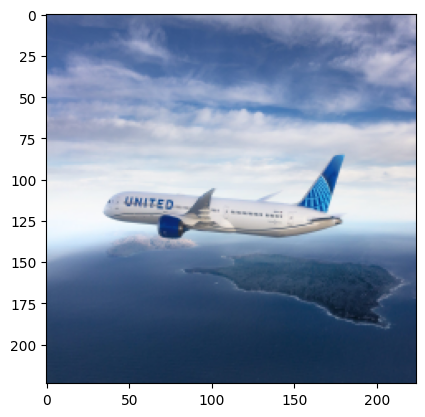

35363/35363 [==============================] - 0s 1us/step
This is a Airliner. I am 89.27 % sure.

Other suggestions:
Wing: 10.72 %
Airship: 0.01 %
Warplane: 0.0 %
Space Shuttle: 0.0 %
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TypeError: BaseGradientDescent.run() takes 4 positional arguments but 5 were given

In [6]:
input_directory  = os.path.join(path_project_root, 'final_dir\images\input')
for filename in os.listdir(input_directory):
    image_index = 0
    filepath = os.path.join(input_directory, filename)
    if os.path.isfile(filepath):
        img = load_img(filepath)
        plt.imshow(img)
        plt.show()
        # img_PDG = get_attacked_image_FGSM(image = img, debug=True, attack_rate=100)
        img_PDG = get_attacked_image_PGD(orig_img=img, class_target=999, debug=True, attack_rate=1)
        plt.imshow(img_PDG)
        plt.show()


# Metric

In [11]:
# Ouvrir les cartes de saillance
def img_open(path_sal_map,path_attacked_sal_map):
    img1 = cv2.imread(path_sal_map)
    img2 = cv2.imread(path_attacked_sal_map)
    return img1,img2

# Calcul de la différence absolue
# Plus la valeur est proche de 0 plus les images sont similaires
def diff_abs(path_sal_map,path_attacked_sal_map):
    img1 = cv2.imread(path_sal_map)
    img2 = cv2.imread(path_attacked_sal_map)
    return np.sum(np.abs(img1 - img2))

# Calcul de la différence quadratique (mse)
# Plus la valeur est proche de 0 plus les images sont similaires
def diff_quadratique(path_sal_map,path_attacked_sal_map):
    img1, img2 = img_open(path_sal_map,path_attacked_sal_map)
    return np.sum(np.square(img1 - img2))

# Calcul du coef de corrélation
# Plus la valeur est proche de 1 plus les images sont similaires
def coef_correlation(path_sal_map,path_attacked_sal_map):
    img1, img2 = img_open(path_sal_map,path_attacked_sal_map)
    result = pearsonr(img1.flatten(),img2.flatten())
    return result.statistic

# Calcul du ssim Structural Similarity Index
# Plus la valeur est proche de 1 plus les images sont similaires
def ssim_func(path_sal_map,path_attacked_sal_map):
    img1 = cv2.imread(path_sal_map)
    img2 = cv2.imread(path_attacked_sal_map)
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    valssim = ssim(gray_img1, gray_img2)
    return valssim


# MAIN PROGRAM

If 1 image is 100Ko => 40Mo generated for each input image

In [13]:
models_availables = ["MobileNetV2", "VGG16", "ResNet152V2"]
attacks_availables = ["PGD", "FGSM"]
input_directory  = os.path.join(path_project_root, 'final_dir\images\input')
output_directory = os.path.join(path_project_root, 'final_dir\images\output\\')
index_images_model = [404, 294, 500, 1, 576, 587, 606, 413]

for model_name in models_availables:
    model = load_model(model_name)
    saliency = get_saliency_object(model)
    for attack_name in attacks_availables:
        for attack_rate in range(2, 100, 2):
            for filename in os.listdir(input_directory):
                image_index = 0
                filepath = os.path.join(input_directory, filename)
                if os.path.isfile(filepath):

                    score = get_score_function([index_images_model[image_index]])

                    original_image = get_image(filepath, model_name)
                    saliency_image = saliency(score, original_image)[0]

                    attacked_image=""
                    if attack_name=="PDG":
                        attacked_image = get_attacked_image_PGD(orig_img=original_image, attack_rate=attack_rate)
                    elif attack_name=="FGSM":
                        attacked_image = get_attacked_image_FGSM(image=original_image, image_index=image_index, model=model, attack_rate=attack_rate)
                    
                    confidence = model.predict(attacked_image)[index_images_model[image_index]]
                    confidence = round(confidence*100000)
                    
                    attacked_saliency_image = saliency(score, attacked_image)[0]

                    filename_output = filename[0:-4] + "_" + model_name + "_" + attack_name + "_" + str(attack_rate) + "_" + confidence
                    
                    original_image_array = (np.array(original_image)+1)/2
                    plt.imsave(output_directory + filename_output + "_nosaliency_noattacked" + ".png", original_image_array)
                    plt.imsave(output_directory + filename_output + "_saliency_noattacked"   + ".png", saliency_image)
                    plt.imsave(output_directory + filename_output + "_nosaliency_attacked"   + ".png", attacked_image)
                    plt.imsave(output_directory + filename_output + "_saliency_attacked"     + ".png", attacked_saliency_image)
                    
                    image_index+=1

Executing : Load Model
Executing : Create Saliency Object
Executing : Create Score Function
Executing : Load And Preprocess Image


ValueError: seed_input's shape is invalid. model-input index: 0, model-input shape: (None, 224, 224, 3), seed_input shape: ().